
# python modules required
1. os - for file path manipulations
2. numpy - for array operation
3. shuffle - to shuffle the training set
4. matplotlib.pyplot - to test image which is converted
5. image - to load and resize the image.
6. Keras with Tensorflow backend

In [2]:
import os
import sys
from PIL import Image
import numpy as np
#from keras_squeezenet import SqueezeNet
from random import shuffle
import matplotlib.pyplot as plt
#from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras

import os
test pil image
numpy
shuffle
plt


Using TensorFlow backend.


55


# function 'label_field_type(name)

1. Takes the argument name which is the class specifier in this case(crop type).

2. returns a one hot encoded np array for each class.

3. right now the return array is hard coded for each class type, incase of more classes it can created dynamically.

In [3]:
#one hot encoding label for each type of field
def label_field_type(name):
    if name == 'alfalfa': return np.array([1, 0, 0, 0, 0])
    elif name == 'barley' : return np.array([0, 1, 0, 0, 0])
    elif name == 'corn' : return np.array([0, 0, 1, 0, 0])
    elif name == 'soybean' : return np.array([0, 0, 0, 1, 0])
    elif name == 'wheat' : return np.array([0, 0, 0, 0, 1])

#  function 'load_training_data()'

1. Returns a list object

2. Each list element is a list containing 2 elements; first element being the image data(224,224,3), the second element is the one hot encoded label for that data.

3. shuffle function is used to shuffle the training data.



In [4]:
#provide the path of the imgs_de directory
folder = "/mnt/d/Python/Granular_img_pipeline/imgs_de"
def load_training_data():
    train_data = []
    crops = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
    for crop in crops:
        label = label_field_type(crop)
        path = os.path.join(folder, crop)
        onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        print("Converting {0} images in crop type {1}".format(len(onlyfiles), crop))
        for image_file in onlyfiles:
            if "DS_Store" not in image_file:
                img_path = os.path.join(path, image_file)
                #print(img_path)
                try:
                    img = image.load_img(img_path, target_size=(224, 224))
                    train_data.append([np.array(img), label])
                except:
                    print("Error occured while reading {}, this file may be skipped".format(image_file))      
    shuffle(train_data)
    return train_data


Calling the function load_training_data and saving the output to train_data
The shape of random objects are tested to see the the output is as expected
plt.imshow(train_data[0][0]) is used to test the converstion

Converting 42 images in crop type alfalfa
Converting 40 images in crop type barley
Converting 49 images in crop type corn
Error occured while reading 30812628187_65a340080c_z.jpg, this file may be skipped
Converting 56 images in crop type soybean
Converting 48 images in crop type wheat
(224, 224, 3)
[1 0 0 0 0]
(224, 224, 3)
[0 0 1 0 0]


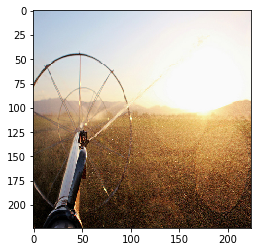

In [5]:
train_data = load_training_data()

print(train_data[0][0].shape)
print(train_data[0][1])
print(train_data[1][0].shape)
print(train_data[1][1])

plt.imshow(train_data[0][0])


# Image augmentation
1. Image augmentation allows training sets to be more accurate with limited training information.
2. train_generator is a DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.


In [41]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

directory_path = "/mnt/d/Python/Granular_img_pipeline/imgs_de"
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)   #not used for now

# this is a generator that will read pictures found in
# subfolers of '/mnt/d/Python/Granular_img_pipeline/imgs_de', and indefinitely generate
# batches of augmented image data of size (224,224,3)
train_generator = train_datagen.flow_from_directory(
        directory_path,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        color_mode='rgb',
        class_mode='categorical',  # since there are multiple crop types
        batch_size=batch_size)  


Found 230 images belonging to 5 classes.


# Testing if train generator is reproducing augmented images.

[0. 0. 0. 0. 1.]


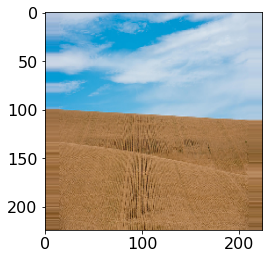

[0. 1. 0. 0. 0.]


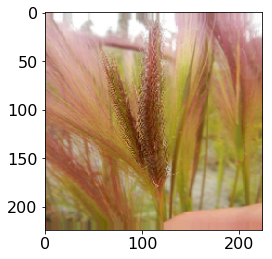

[0. 0. 1. 0. 0.]


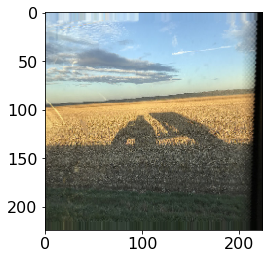

[0. 0. 1. 0. 0.]


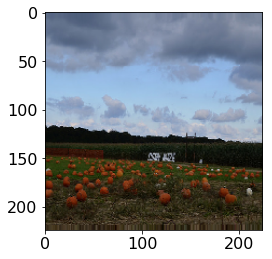

[0. 0. 0. 1. 0.]


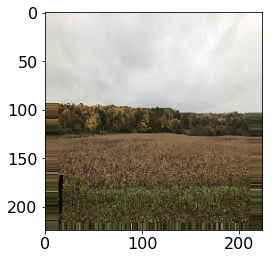

[0. 0. 0. 1. 0.]


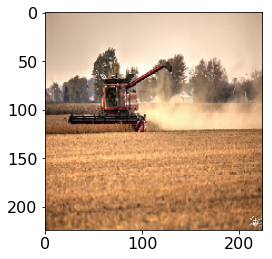

[0. 1. 0. 0. 0.]


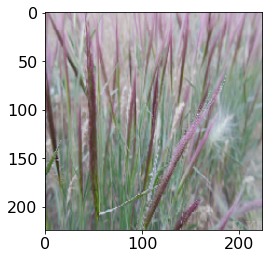

[0. 0. 0. 1. 0.]


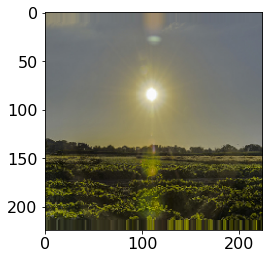

[0. 0. 0. 1. 0.]


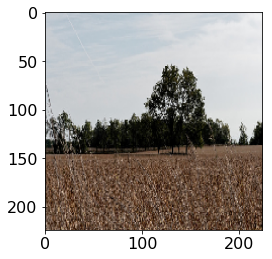

[0. 0. 0. 0. 1.]


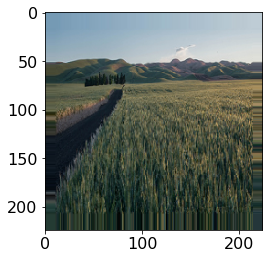

In [48]:
x,y = train_generator.next()
for i in range(0,10):
    image = x[i]
    print(y[i])
    plt.imshow(image)
    plt.show()


# Extracting & visualizing Geographic data using exif

In [6]:
import exifread

# based on https://gist.github.com/erans/983821

def _get_if_exist(data, key):
    if key in data:
        return data[key]

    return None


def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = _get_if_exist(exif_data, 'GPS GPSLatitude')
    gps_latitude_ref = _get_if_exist(exif_data, 'GPS GPSLatitudeRef')
    gps_longitude = _get_if_exist(exif_data, 'GPS GPSLongitude')
    gps_longitude_ref = _get_if_exist(exif_data, 'GPS GPSLongitudeRef')

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon
    

In [7]:
def get_exif_data(image_file):
    with open(image_file, 'rb') as f:
        exif_tags = exifread.process_file(f)
    return exif_tags 




In [8]:

#provide the path of the imgs_de directory
folder = "/mnt/d/Python/Granular_img_pipeline/imgs_de"
def load_exif_data():
    exif_data = []
    crops = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
    for crop in crops:
        label = label_field_type(crop)
        path = os.path.join(folder, crop)
        onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        print("Extracing GPS information from {0} images in crop type {1}".format(len(onlyfiles), crop))
        for image_file in onlyfiles:
            if "DS_Store" not in image_file:
                img_path = os.path.join(path, image_file)
                try:
                #print(img_path)
                    #exif_data.append(get_exif_location(get_exif_data(img_path)))
                    lat, long = get_exif_location(get_exif_data(img_path))
                    exif_data.append([lat,long,crop])
                except:
                    print("Error occured while reading {}, this file may be skipped".format(image_file))      
    return exif_data

In [9]:
exif_data_array = load_exif_data()
#print(exif_data_array)

Converting 42 images in crop type alfalfa
Converting 40 images in crop type barley
Converting 49 images in crop type corn
Converting 56 images in crop type soybean
Converting 48 images in crop type wheat


/home/richytomy/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


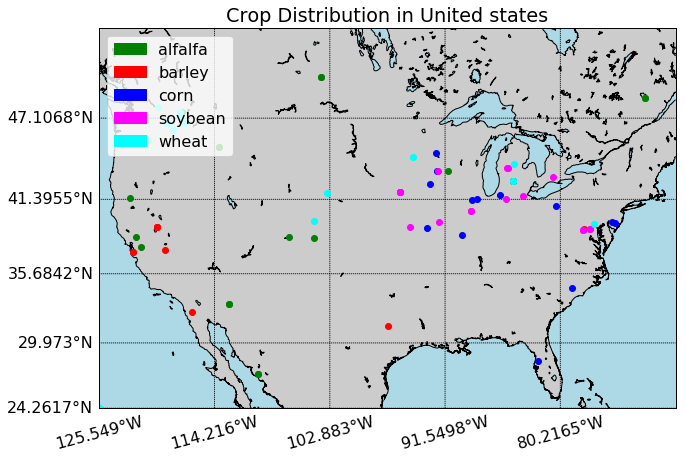

<Figure size 432x288 with 0 Axes>

In [10]:
#!/usr/bin/python
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# setting parameters for title and axes
font = {'family' : 'verdana',
        'size'   : 16}
matplotlib.rc('font', **font)

# Grabbing the .csv data
lats,lons,crop_type = [],[],[]
temp_dat = []
for data in exif_data_array:
    if (data[0])==None or (data[1])==None:
            continue
    lats.append(float(data[0]))
    lons.append(float(data[1]))
    crop_type.append(data[2])
        
# How much to zoom from coordinates (in degrees)
zoom_scale = 3

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

fig, ax = plt.subplots(figsize=(12,7))
plt.title("Crop Distribution in United states")
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='#CCCCCC',lake_color='lightblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
m.drawmapboundary(fill_color='lightblue')


# different colors are set to different crops types
for ii in range(0,len(crop_type)):
    x,y = m(lons[ii],lats[ii])
    if(crop_type[ii] == 'alfalfa'):
        color_interp = 'green'
    elif(crop_type[ii] == 'barley'):
        color_interp = 'red'
    elif(crop_type[ii] == 'corn'):
        color_interp = 'blue'
    elif(crop_type[ii] == 'soybean'):
        color_interp = 'magenta'
    elif(crop_type[ii] == 'wheat'):
        color_interp = 'cyan'
    plt.plot(x,y,3,marker='o',color=color_interp)

alfalfa_green = mpatches.Patch(color='green', label='alfalfa')
barley_red = mpatches.Patch(color='red', label='barley')
corn_blue = mpatches.Patch(color='blue', label='corn')
soybean_magenta = mpatches.Patch(color='magenta', label='soybean')
wheat_cyan = mpatches.Patch(color='cyan', label='wheat')
plt.legend(handles=[alfalfa_green, barley_red, corn_blue, soybean_magenta, wheat_cyan])
plt.show()

# save the figure and show it
plt.savefig('crop_distribution.png', format='png', dpi=500,transparent=True)
plt.show()